# Agrupamento de FIIs
O objetivo desse projeto é utilizar uma técnica de aprendizagem de máquina não supervisionada para agrupar os FIIs de acordo com algumas de suas características e indicadores.

## 1. Importando Bibliotecas

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')
sns.set(context='notebook', palette='dark', color_codes=True)

# Factor Analysis
from prince import MCA
from scipy.stats import chi2_contingency
from scipy.stats import norm

# Clustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree, fcluster
from sklearn.cluster import KMeans, DBSCAN


## 2. Importando Dataset

In [2]:
df = pd.read_csv("data/dados_FIIs_processados.csv")

In [3]:
df.head()

,ticker,nome,tipo_gestao,setor,menos_5_anos,pct_caixa,num_cotistas,PL,PVPA,liquidez_diaria_avg,...,dy_3m_acc,dy_6m_acc,dy_12m_acc,dy_ano,var_preço,rent_periodo,rent_acc,vacancia_fisica,qtd_ativos,valor_mercado
0,SHPH11,Shopping Patio Higienopolis,Passiva,Shoppings,False,0.4134,3105.0,5.013048e+08,0.9803,150895.54,...,0.75,2.23,3.35,1.27,0.00,0.24,-0.33,13.3,1.0,4.914291e+08
1,ALZR11,Alianza Trust Renda Imobiliária,Ativa,Logística,False,1.8679,93070.0,5.450889e+08,1.1276,1676327.17,...,1.59,2.91,4.96,2.91,5.65,6.18,-0.60,0.0,13.0,6.146422e+08
2,BBRC11,BB Renda Corporativa,Passiva,Outros,False,4.0449,8727.0,1.794707e+08,1.0003,201161.93,...,2.30,4.61,8.59,4.61,-3.22,-2.49,-6.74,5.4,20.0,1.795246e+08
3,BTAL11,BTG PACTUAL AGRO LOGÍSTICA,Ativa,Outros,True,33.8504,10544.0,6.132124e+08,0.9588,821338.54,...,1.68,0.00,0.00,2.02,-0.28,0.38,-1.13,0.0,7.0,5.879481e+08
4,BTCR11,BTG Pactual Crédito Imobiliário,Ativa,Títulos e Val. Mob.,False,5.6180,9427.0,4.681521e+08,0.9655,1228057.98,...,2.23,4.24,7.16,4.24,0.83,1.61,10.18,0.0,0.0,4.520008e+08


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ticker               173 non-null    object 
 1   nome                 173 non-null    object 
 2   tipo_gestao          173 non-null    object 
 3   setor                173 non-null    object 
 4   menos_5_anos         173 non-null    bool   
 5   pct_caixa            173 non-null    float64
 6   num_cotistas         173 non-null    float64
 7   PL                   173 non-null    float64
 8   PVPA                 173 non-null    float64
 9   liquidez_diaria_avg  173 non-null    float64
 10  cagr_dividendo       173 non-null    float64
 11  cagr_cota            173 non-null    float64
 12  num_negocios         173 non-null    float64
 13  dy_1m                173 non-null    float64
 14  dy_3m_acc            173 non-null    float64
 15  dy_6m_acc            173 non-null    flo

Pode-se obserar que o dataset possui 3 variáveis categóricas (`tipo_gestao`, `setor` e `menos_5_anos`), sem considerar as variáveis `ticker` e `nome` que servem apenas para identificar o Fundo. As demais 19 variáveis são quantitativas.

As técnicas de agrupamento funcionam tendo como base o conceito de distância que só pode ser calculado entre variáveis quantitativas. Torna-se necessário, dessa forma, a transformação das variáveis categóricas em variáveis numéricas, sem incorrer em ponderação arbitrária. 

## 3. Análise de Correspondência Múltipla

Como possuimos 3 variáveis categóricas, será necessário realizar uma análise de Correspondência Múltipla. 

Primeiramente será necessário realizar testes de chi-quadrado com cada par de variáveis a fim de constatar algum relacionamento entre elas.

### 3.1. Teste de Chi Quadrado
#### 3.1.1. Setor x Tipo de Gestão

In [5]:
cont_tab = pd.crosstab(df['setor'], df['tipo_gestao'])
cont_tab

tipo_gestao,Ativa,Passiva
setor,,
Hospital,0,2
Hotel,1,0
Híbrido,24,2
Lajes Corporativas,10,12
Logística,15,2
Outros,21,4
Residencial,2,0
Shoppings,8,7
Títulos e Val. Mob.,59,4


In [6]:
def eval_chi2(cont_tab):
    chi2, p, dof, _ = chi2_contingency(cont_tab, correction=False)
    print(f"Chi-quadrado: {chi2:.2f}")
    print(f"P-value: {p}")
    print(f"Graus de Liberdade: {dof}")
    print("-------")
    if p < 0.05:
        print('É possível rejeitar a hipótese nula de que as variáveis se associam ao acaso.')
    else:
        print("NÃO É possível rejeitar a hipótese nula de que as variáveis se associam ao acaso.")


In [7]:
eval_chi2(cont_tab)

Chi-quadrado: 44.05
P-value: 5.557130715586873e-07
Graus de Liberdade: 8
-------
É possível rejeitar a hipótese nula de que as variáveis se associam ao acaso.


#### 3.1.2. Setor x Menos de 5 Anos

In [8]:
cont_tab = pd.crosstab(df['setor'], df['menos_5_anos'])
cont_tab

menos_5_anos,False,True
setor,,
Hospital,2,0
Hotel,1,0
Híbrido,11,15
Lajes Corporativas,13,9
Logística,9,8
Outros,10,15
Residencial,0,2
Shoppings,10,5
Títulos e Val. Mob.,25,38


In [9]:
eval_chi2(cont_tab)

Chi-quadrado: 11.10
P-value: 0.1963118462474281
Graus de Liberdade: 8
-------
NÃO É possível rejeitar a hipótese nula de que as variáveis se associam ao acaso.


#### 3.1.3. Tipo de Gestão x Menos de 5 Anos

In [10]:
cont_tab = pd.crosstab(df['tipo_gestao'], df['menos_5_anos'])
cont_tab

menos_5_anos,False,True
tipo_gestao,,
Ativa,53,87
Passiva,28,5


In [11]:
eval_chi2(cont_tab)

Chi-quadrado: 23.68
P-value: 1.1353569627207682e-06
Graus de Liberdade: 1
-------
É possível rejeitar a hipótese nula de que as variáveis se associam ao acaso.


### 3.2. Análise de Correspondência

Como houve significância estatística na associação em, pelo menos, um dos casos, a análise de correspondência pode ser realizada.

Como o objetivo dessa análise de correspondência múltipla é transformar as variáveis categoricas em variáveis numéricas, todos os **10 componentes** (13 categorias - 3 variáveis) serão utilizados.

In [12]:
df_cat = df.iloc[:,2:5].astype(str)

componentes = df[['menos_5_anos', 'tipo_gestao', 'setor']].nunique().sum() - 3

mca = MCA(n_components = componentes, n_iter = 3, random_state = 42)
mca.fit(df_cat)

df_mca = mca.transform(df_cat)
df_mca.columns = map(lambda x: "V" + str(x), df_mca.columns)

df_mca.head()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9
0,1.577637,0.183631,-0.144294,0.951893,0.412388,-0.873057,-0.605294,0.664251,0.202058,0.271189
1,0.081298,0.952733,-0.295913,0.732139,-1.105389,0.231115,0.091768,-0.767056,-0.239492,-0.220551
2,0.977318,-0.307159,0.169010,-0.020327,-0.640878,0.307243,0.367487,1.069975,-0.638125,0.703834
3,-0.542586,-0.457999,0.169010,-0.020327,-0.640878,0.307243,0.367487,1.069975,0.163955,-0.018615
4,-0.091541,0.311390,-0.472190,-0.339444,0.246898,-0.182798,-0.055808,-0.075683,-0.671755,-0.202932


In [13]:
mca_summary = pd.DataFrame({'Autovalor' : mca.eigenvalues_, 
                            '% da Var.' : mca.explained_inertia_, 
                            '% da Var. Acumulada' : np.cumsum(mca.explained_inertia_)})
mca_summary

,Autovalor,% da Var.,% da Var. Acumulada
0,0.579330,0.173799,0.173799
1,0.353884,0.106165,0.279964
2,0.333333,0.100000,0.379964
3,0.333333,0.100000,0.479964
4,0.333333,0.100000,0.579964
5,0.333333,0.100000,0.679964
6,0.333333,0.100000,0.779964
7,0.333333,0.100000,0.879964
8,0.249068,0.074720,0.954685
9,0.151051,0.045315,1.000000


Conforme a tabela acima é possível observar que os 10 componentes conseguem representar 100% da inércia total dos dados.

Com esse procedimento as 3 variáveis categóricas foram transformadas em 10 variáveis quantitativas que se juntarão as outras para que os agrupamentos possam ser montados.

## 4. Juntando os Dados

Primeiro vamos adicionar os tickers dos FIIs como índices do `df_mca`.

In [14]:
df_mca['ticker'] = df['ticker']

df_mca.set_index('ticker', inplace = True)

df_mca.head()


,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9
ticker,,,,,,,,,,
SHPH11,1.577637,0.183631,-0.144294,0.951893,0.412388,-0.873057,-0.605294,0.664251,0.202058,0.271189
ALZR11,0.081298,0.952733,-0.295913,0.732139,-1.105389,0.231115,0.091768,-0.767056,-0.239492,-0.220551
BBRC11,0.977318,-0.307159,0.169010,-0.020327,-0.640878,0.307243,0.367487,1.069975,-0.638125,0.703834
BTAL11,-0.542586,-0.457999,0.169010,-0.020327,-0.640878,0.307243,0.367487,1.069975,0.163955,-0.018615
BTCR11,-0.091541,0.311390,-0.472190,-0.339444,0.246898,-0.182798,-0.055808,-0.075683,-0.671755,-0.202932


Agora vamos criar um novo DataFrame como base nos dados originais, selecionando somente as variáveis quantitativas.

Por fim precisamos padronizar as variáveis, visto que elas estão em escalas diferentes.

In [15]:
df_clus = df.copy()

df_clus.set_index('ticker', inplace = True)

df_clus.drop(['nome', 'tipo_gestao', 'setor', 'menos_5_anos'], axis = 1, inplace = True)

df_clus = pd.DataFrame(StandardScaler().fit_transform(df_clus), 
                       columns=df_clus.columns, 
                       index = df_clus.index)

df_std = df_clus.copy()

df_clus.head()

,pct_caixa,num_cotistas,PL,PVPA,liquidez_diaria_avg,cagr_dividendo,cagr_cota,num_negocios,dy_1m,dy_3m_acc,dy_6m_acc,dy_12m_acc,dy_ano,var_preço,rent_periodo,rent_acc,vacancia_fisica,qtd_ativos,valor_mercado
ticker,,,,,,,,,,,,,,,,,,,
SHPH11,-0.581363,-0.540372,-0.216088,0.230465,-0.658517,-1.154686,-0.841473,-0.433001,-0.727959,-1.147317,-0.591135,-0.546564,-1.185064,0.568155,0.406705,0.299703,0.545492,-0.349243,-0.199081
ALZR11,-0.496524,0.939091,-0.161060,1.083118,0.041957,-0.565301,1.506633,-0.297438,-0.393198,-0.387216,-0.290819,-0.195542,-0.437595,2.001115,1.821095,0.276096,-0.391803,0.966597,-0.044905
BBRC11,-0.369541,-0.447919,-0.620569,0.346235,-0.635435,0.123634,-0.962779,-0.424184,-0.045048,0.255250,0.459970,0.595890,0.337220,-0.248505,-0.243343,-0.260752,-0.011247,1.734170,-0.589364
BTAL11,1.368984,-0.418038,-0.075442,0.106011,-0.350651,0.052488,0.084895,-0.320126,-0.165561,-0.305777,-1.575995,-1.276949,-0.843234,0.497141,0.440041,0.229756,-0.391803,0.308677,-0.078307
BTCR11,-0.277784,-0.436407,-0.257754,0.144794,-0.163887,-0.617165,0.084895,-0.355745,-0.018267,0.191908,0.296563,0.284114,0.168584,0.778661,0.732920,1.218641,-0.391803,-0.458896,-0.248417


Unimos ambos os dataframes

In [16]:
df_clus = pd.merge(df_clus, df_mca, left_index=True, right_index=True, how = 'inner')
df_clus.head()

,pct_caixa,num_cotistas,PL,PVPA,liquidez_diaria_avg,cagr_dividendo,cagr_cota,num_negocios,dy_1m,dy_3m_acc,...,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9
ticker,,,,,,,,,,,,,,,,,,,,,
SHPH11,-0.581363,-0.540372,-0.216088,0.230465,-0.658517,-1.154686,-0.841473,-0.433001,-0.727959,-1.147317,...,1.577637,0.183631,-0.144294,0.951893,0.412388,-0.873057,-0.605294,0.664251,0.202058,0.271189
ALZR11,-0.496524,0.939091,-0.161060,1.083118,0.041957,-0.565301,1.506633,-0.297438,-0.393198,-0.387216,...,0.081298,0.952733,-0.295913,0.732139,-1.105389,0.231115,0.091768,-0.767056,-0.239492,-0.220551
BBRC11,-0.369541,-0.447919,-0.620569,0.346235,-0.635435,0.123634,-0.962779,-0.424184,-0.045048,0.255250,...,0.977318,-0.307159,0.169010,-0.020327,-0.640878,0.307243,0.367487,1.069975,-0.638125,0.703834
BTAL11,1.368984,-0.418038,-0.075442,0.106011,-0.350651,0.052488,0.084895,-0.320126,-0.165561,-0.305777,...,-0.542586,-0.457999,0.169010,-0.020327,-0.640878,0.307243,0.367487,1.069975,0.163955,-0.018615
BTCR11,-0.277784,-0.436407,-0.257754,0.144794,-0.163887,-0.617165,0.084895,-0.355745,-0.018267,0.191908,...,-0.091541,0.311390,-0.472190,-0.339444,0.246898,-0.182798,-0.055808,-0.075683,-0.671755,-0.202932


## 5. Agrupamentos (Clustering)

Vamos utilizar diferentes técnicas de agrupamentos para analisar os diferentes tipos de resultados e escolher o que mais se adequa ao nosso caso.

### 5.1. Métodos Hierárquicos

Primeiro vamos definir algumas funções auxiliares:

In [17]:
def plot_dendrogram(cluster, limit_distance = 2, readable = True):
    if readable:
        fig_size = (25, 40)
        leaf_rot = 0
        orientation = 'right'
        font = 10
        plot_line = plt.vlines
    else:
        fig_size = (18, 10)
        leaf_rot = 90
        orientation = 'top'
        font = 6
        plot_line = plt.hlines
    
    
    fig = plt.figure(figsize=fig_size)
    dn = dendrogram(cluster, 
                    labels = df_clus.index, 
                    leaf_rotation = leaf_rot, 
                    color_threshold= limit_distance, 
                    orientation = orientation, 
                    leaf_font_size = font)
    plot_line(limit_distance, 0, 10000, linestyle='dashed', color='black')

In [18]:
def cluster_composition(groups):
    d = pd.DataFrame({"Grupo" : groups, 'ticker' : df_clus.index})
    dg = d.groupby('Grupo').count()
    dg.columns = ['Quantidade']
    dg['Quantidade (%)'] = dg['Quantidade']*100/len(d)
    
    print(dg)

def cluster_composition_h(cluster, threshold):
    groups = fcluster(cluster, threshold, criterion = 'distance')
    cluster_composition(groups)
    
    

#### 5.1.1. Vizinho Mais Próximo e Distância Euclidiana

In [19]:
cluster_single = linkage(df_clus, method = 'single', metric = 'euclidean')
c_temp = cluster_single

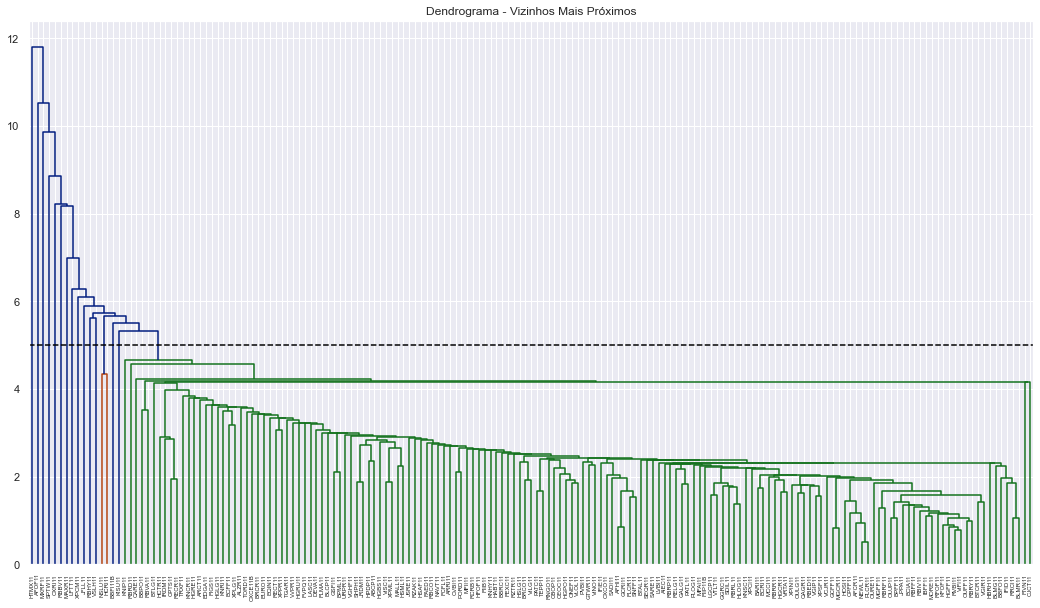

In [20]:
limit_distance = 5
plot_dendrogram(c_temp, limit_distance, readable=False)
plt.title("Dendrograma - Vizinhos Mais Próximos")
plt.show()

Gerou muitos grupos de um único FII e um grande grupo com vários FIIs.

In [21]:
cluster_composition_h(c_temp, limit_distance)

       Quantidade  Quantidade (%)
Grupo                            
1               1        0.578035
2               1        0.578035
3               2        1.156069
4             157       90.751445
5               1        0.578035
6               1        0.578035
7               1        0.578035
8               1        0.578035
9               1        0.578035
10              1        0.578035
11              1        0.578035
12              1        0.578035
13              1        0.578035
14              1        0.578035
15              1        0.578035
16              1        0.578035


#### 5.1.2. Vizinho Mais Longe e Distância Euclidiana

In [22]:
cluster_complete = linkage(df_clus, method = 'complete', metric = 'euclidean')
c_temp = cluster_complete

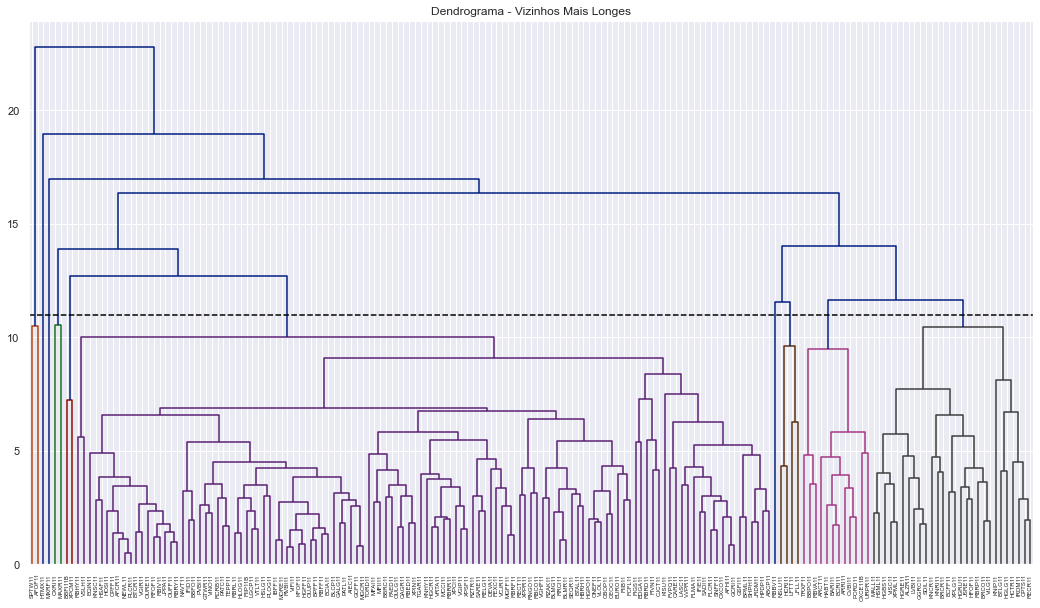

In [23]:
limit_distance = 11
plot_dendrogram(cluster_complete, limit_distance, readable=False)
plt.title("Dendrograma - Vizinhos Mais Longes")
plt.show()

Já foi possível alcançar uma melhor distribuição de grupos, porém ainda possui um grupo muito grande e foi necessário agrupar fundos com grandes distâncias.cluster_composition(cluster_single, limit_distance)

In [24]:
cluster_composition_h(c_temp, limit_distance)

       Quantidade  Quantidade (%)
Grupo                            
1               2        1.156069
2               2        1.156069
3               2        1.156069
4             120       69.364162
5               4        2.312139
6               1        0.578035
7              12        6.936416
8              28       16.184971
9               1        0.578035
10              1        0.578035


#### 5.1.3. Vizinho Médio e Distância Euclidiana

In [25]:
cluster_average = linkage(df_clus, method = 'average', metric = 'euclidean')
c_temp = cluster_average

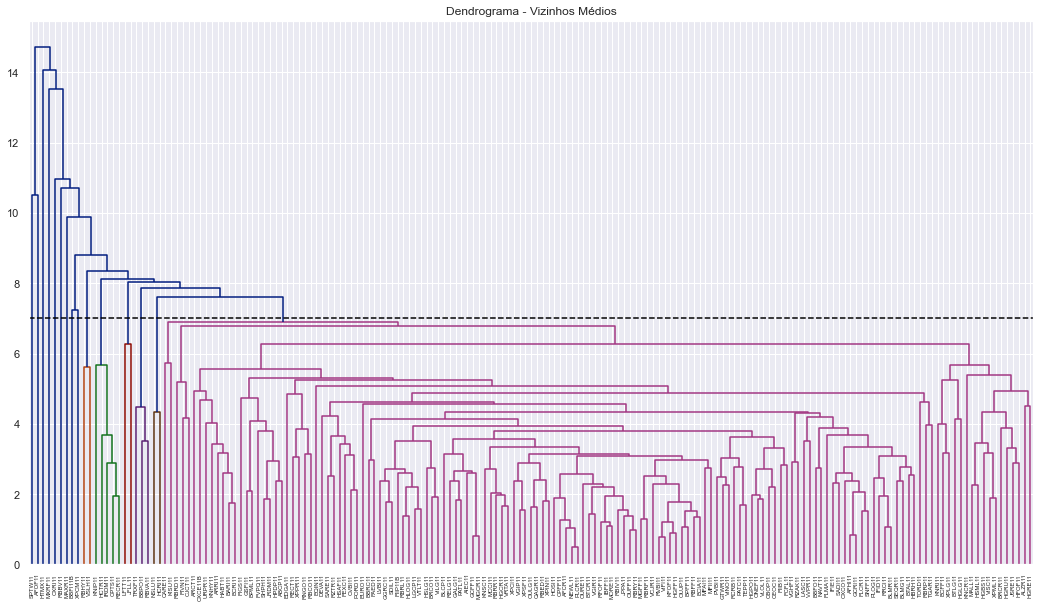

In [26]:
limit_distance = 7
plot_dendrogram(cluster_average, limit_distance, readable=False)
plt.title("Dendrograma - Vizinhos Médios")
plt.show()

Novamente, os fundos acabam se concentrando em um grande grupo.

In [27]:
cluster_composition_h(c_temp, limit_distance)

       Quantidade  Quantidade (%)
Grupo                            
1               1        0.578035
2               1        0.578035
3               1        0.578035
4               1        0.578035
5               2        1.156069
6               5        2.890173
7               2        1.156069
8               3        1.734104
9               2        1.156069
10            150       86.705202
11              1        0.578035
12              1        0.578035
13              1        0.578035
14              1        0.578035
15              1        0.578035


#### 5.1.4. Centróide e Distância Euclidiana

In [28]:
cluster_centroid = linkage(df_clus, method = 'centroid', metric = 'euclidean')
c_temp = cluster_centroid

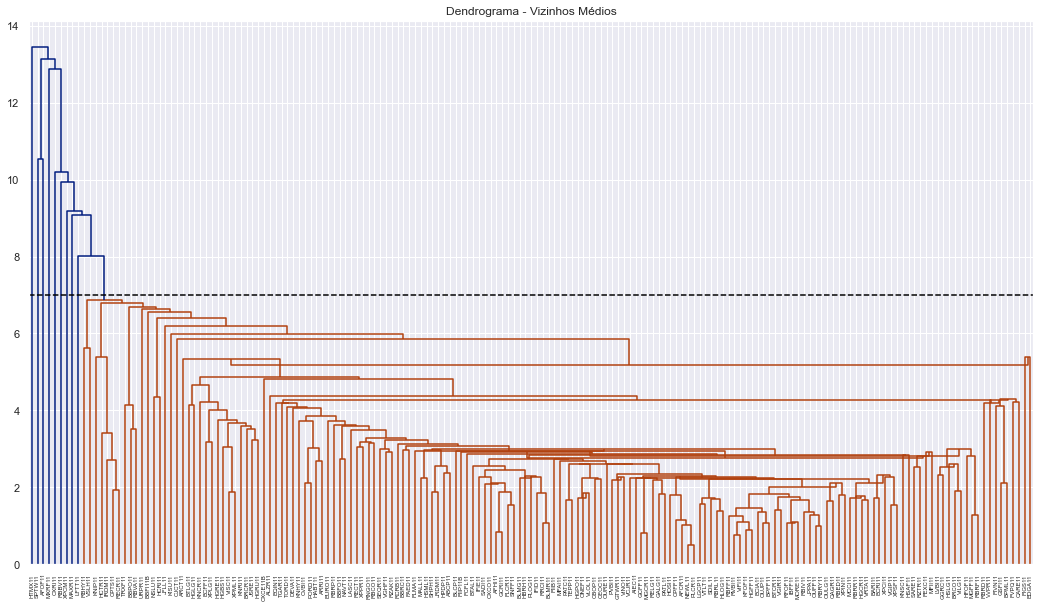

In [29]:
limit_distance = 7
plot_dendrogram(cluster_centroid, limit_distance, readable=False)
plt.title("Dendrograma - Vizinhos Médios")
plt.show()

In [30]:
cluster_composition_h(c_temp, limit_distance)

       Quantidade  Quantidade (%)
Grupo                            
1               1        0.578035
2               1        0.578035
3             164       94.797688
4               1        0.578035
5               1        0.578035
6               1        0.578035
7               1        0.578035
8               1        0.578035
9               1        0.578035
10              1        0.578035


cluster_composition(c_temp, limit_distance)

#### 5.1.5. Ward e Distância Euclidiana

In [31]:
cluster_ward = linkage(df_clus, method = 'ward', metric = 'euclidean')
c_temp = cluster_ward

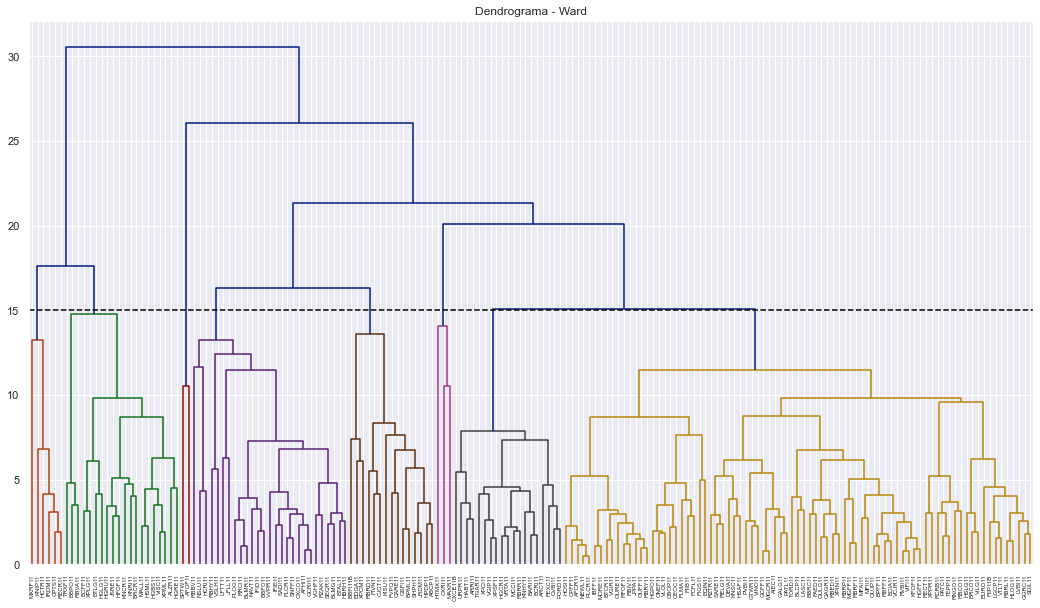

In [32]:
limit_distance = 15
plot_dendrogram(cluster_ward, limit_distance, readable=False)
plt.title("Dendrograma - Ward")
plt.show()

Com o algorítimo de Ward (minimiza a variância), conseguiu agrupar os Fundos em grupos mais bem distribuidos.

In [33]:
cluster_composition_h(c_temp, limit_distance)
grupos_ward = fcluster(c_temp, limit_distance, criterion = 'distance')

       Quantidade  Quantidade (%)
Grupo                            
1               6        3.468208
2              20       11.560694
3               2        1.156069
4              27       15.606936
5              15        8.670520
6               3        1.734104
7              19       10.982659
8              81       46.820809


#### 5.1.6. Vizinho Mais Longe com Similaridade de Correlação

In [34]:
cluster_comp_corr = linkage(df_clus, method = 'complete', metric = 'correlation')
c_temp = cluster_comp_corr

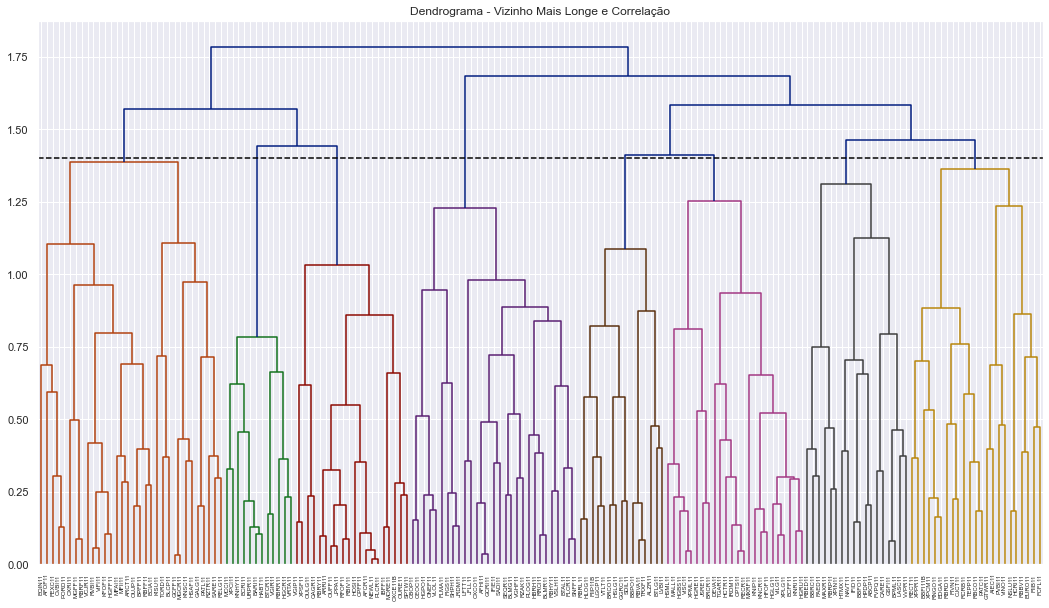

In [35]:
limit_distance = 1.4
plot_dendrogram(cluster_comp_corr, limit_distance, readable=False)
plt.title("Dendrograma - Vizinho Mais Longe e Correlação")
plt.show()

Há uma boa separação de grupos, mais ou menos homogênios em quantidade de ativos.

In [36]:
cluster_composition_h(c_temp, limit_distance)
grupos_complete_corr = fcluster(c_temp, limit_distance, criterion = 'distance')

       Quantidade  Quantidade (%)
Grupo                            
1              32       18.497110
2              12        6.936416
3              20       11.560694
4              29       16.763006
5              15        8.670520
6              24       13.872832
7              18       10.404624
8              23       13.294798


### 5.2. Métodos Não-hierárquicos

#### 5.2.1. KMeans

In [37]:
test_range = range(1,40)
models_kmeans = []

for n in test_range:
    models_kmeans.append( KMeans(n_clusters = n).fit(df_clus) )

C:\Users\Daniel Souza - PC\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Elbow Plot

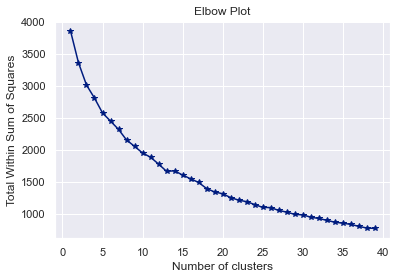

In [38]:
plt.plot(list(test_range), [model.inertia_ for model in models_kmeans], '*-')

plt.title("Elbow Plot")
plt.xlabel("Number of clusters")
plt.ylabel("Total Within Sum of Squares")

plt.show()

Com base no ELbow plot irei definir 12 clusters.

In [39]:
k = 12
model_kmeans = models_kmeans[k-1]

In [40]:
model_kmeans.n_clusters

12

In [41]:
cluster_composition(model_kmeans.labels_)

       Quantidade  Quantidade (%)
Grupo                            
0              13        7.514451
1              36       20.809249
2              13        7.514451
3              30       17.341040
4               7        4.046243
5               1        0.578035
6               1        0.578035
7              10        5.780347
8               2        1.156069
9              56       32.369942
10              3        1.734104
11              1        0.578035


Houve uma boa separação dos dados, entretanto alguns FIIs ficaram em grupos isolados. Serão analisados mais a frente.

#### 5.2.2. DBSCAN

In [42]:
model_dbscan = DBSCAN(eps = 0.3, min_samples = 2, metric='correlation').fit(df_clus)

In [43]:
cluster_composition(model_dbscan.labels_)

       Quantidade  Quantidade (%)
Grupo                            
-1             44       25.433526
 0              8        4.624277
 1             69       39.884393
 2              7        4.046243
 3              6        3.468208
 4              2        1.156069
 5              6        3.468208
 6              6        3.468208
 7              2        1.156069
 8              2        1.156069
 9             12        6.936416
 10             2        1.156069
 11             2        1.156069
 12             2        1.156069
 13             3        1.734104


Com algorítimo do DBSCAN os agrupamentos sempre resultaram em situações com 1 grupo muito grande, alguns muito pequenos e uma quantidade razoável de outliers (grupo -1).

## 6. Análise de Resultados

Apesar de não ser necessário que os agrupamentos sejam bem divididos entre os grupos, o conhecimento prévio dos Fundos Imobiliários "me diz" que deve haver algumas diferentes classificações que não sejam concentradas em um único grupo. Dessa forma, analisarei mais a fundo o resultado de 2 técnicas:

 - Agrupamento Hierárquico com o Método de Vizinhos Mais Longes e Similaridade de Correlação,
 - Agrupamento Hierárquico com o Método de Ward e Distância Euclidiana.

In [44]:
grupos_complete_corr

array([4, 5, 7, 4, 2, 5, 6, 3, 4, 1, 6, 1, 4, 8, 5, 8, 4, 4, 7, 1, 7, 8,
       3, 7, 7, 4, 4, 6, 6, 2, 6, 6, 1, 4, 5, 5, 6, 7, 1, 1, 1, 3, 8, 4,
       3, 1, 3, 3, 1, 8, 8, 7, 1, 1, 5, 7, 3, 6, 8, 3, 8, 4, 4, 4, 3, 6,
       1, 2, 1, 4, 3, 5, 7, 7, 3, 4, 1, 8, 4, 4, 2, 6, 1, 2, 1, 8, 1, 7,
       5, 6, 1, 4, 7, 7, 2, 8, 6, 6, 5, 6, 6, 5, 1, 6, 4, 7, 4, 2, 8, 5,
       6, 7, 8, 1, 7, 3, 1, 8, 3, 8, 4, 3, 6, 3, 7, 6, 1, 3, 4, 5, 5, 1,
       3, 1, 4, 2, 1, 6, 4, 1, 1, 8, 8, 4, 3, 8, 1, 1, 1, 5, 3, 8, 8, 2,
       4, 1, 4, 2, 1, 2, 4, 5, 7, 2, 8, 6, 8, 6, 4, 6, 6, 8, 3],
      dtype=int32)

In [45]:
grupos_ward

array([5, 2, 8, 4, 8, 2, 1, 7, 4, 6, 8, 7, 8, 8, 8, 5, 4, 8, 5, 8, 5, 8,
       8, 5, 4, 4, 5, 2, 2, 7, 1, 2, 8, 4, 8, 8, 2, 6, 8, 8, 8, 8, 4, 8,
       8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 1, 8, 8, 8, 4, 4, 4, 3, 7,
       8, 7, 8, 4, 7, 8, 8, 5, 8, 4, 3, 8, 8, 8, 7, 2, 8, 7, 8, 5, 8, 5,
       8, 2, 8, 4, 4, 5, 7, 5, 2, 2, 2, 2, 2, 8, 7, 1, 4, 8, 4, 7, 5, 8,
       2, 8, 8, 7, 6, 8, 8, 8, 7, 4, 4, 8, 1, 8, 4, 1, 8, 8, 4, 2, 8, 5,
       8, 8, 4, 7, 8, 2, 8, 8, 8, 8, 8, 4, 8, 5, 8, 7, 8, 8, 8, 8, 8, 7,
       4, 8, 4, 8, 8, 7, 4, 2, 4, 7, 5, 8, 8, 2, 8, 2, 2, 8, 7],
      dtype=int32)

Para obter analisar as características de cada agrupamento irei utilizar as variáveis métricas padronizadas e as variáveis categóricas transformadas em dummies.

In [46]:
df.set_index('ticker', inplace = True)

In [47]:
df_dummies = pd.get_dummies(data=df.loc[:,['menos_5_anos', 'tipo_gestao', 'setor']], columns=['menos_5_anos', 'tipo_gestao', 'setor'])
df_dummies.head()

,menos_5_anos_False,menos_5_anos_True,tipo_gestao_Ativa,tipo_gestao_Passiva,setor_Hospital,setor_Hotel,setor_Híbrido,setor_Lajes Corporativas,setor_Logística,setor_Outros,setor_Residencial,setor_Shoppings,setor_Títulos e Val. Mob.
ticker,,,,,,,,,,,,,
SHPH11,1,0,0,1,0,0,0,0,0,0,0,1,0
ALZR11,1,0,1,0,0,0,0,0,1,0,0,0,0
BBRC11,1,0,0,1,0,0,0,0,0,1,0,0,0
BTAL11,0,1,1,0,0,0,0,0,0,1,0,0,0
BTCR11,1,0,1,0,0,0,0,0,0,0,0,0,1


In [48]:
df_std.head()

,pct_caixa,num_cotistas,PL,PVPA,liquidez_diaria_avg,cagr_dividendo,cagr_cota,num_negocios,dy_1m,dy_3m_acc,dy_6m_acc,dy_12m_acc,dy_ano,var_preço,rent_periodo,rent_acc,vacancia_fisica,qtd_ativos,valor_mercado
ticker,,,,,,,,,,,,,,,,,,,
SHPH11,-0.581363,-0.540372,-0.216088,0.230465,-0.658517,-1.154686,-0.841473,-0.433001,-0.727959,-1.147317,-0.591135,-0.546564,-1.185064,0.568155,0.406705,0.299703,0.545492,-0.349243,-0.199081
ALZR11,-0.496524,0.939091,-0.161060,1.083118,0.041957,-0.565301,1.506633,-0.297438,-0.393198,-0.387216,-0.290819,-0.195542,-0.437595,2.001115,1.821095,0.276096,-0.391803,0.966597,-0.044905
BBRC11,-0.369541,-0.447919,-0.620569,0.346235,-0.635435,0.123634,-0.962779,-0.424184,-0.045048,0.255250,0.459970,0.595890,0.337220,-0.248505,-0.243343,-0.260752,-0.011247,1.734170,-0.589364
BTAL11,1.368984,-0.418038,-0.075442,0.106011,-0.350651,0.052488,0.084895,-0.320126,-0.165561,-0.305777,-1.575995,-1.276949,-0.843234,0.497141,0.440041,0.229756,-0.391803,0.308677,-0.078307
BTCR11,-0.277784,-0.436407,-0.257754,0.144794,-0.163887,-0.617165,0.084895,-0.355745,-0.018267,0.191908,0.296563,0.284114,0.168584,0.778661,0.732920,1.218641,-0.391803,-0.458896,-0.248417


In [49]:
df_std.shape

(173, 19)

### 6.1. Análise Vizinhos Mais Longes

In [50]:
df_std_ml = df_std.copy()
df_dum_ml = df_dummies.copy()
df_std_ml['cluster'] = grupos_complete_corr
df_dum_ml['cluster'] = grupos_complete_corr

df_std_ml.head()

,pct_caixa,num_cotistas,PL,PVPA,liquidez_diaria_avg,cagr_dividendo,cagr_cota,num_negocios,dy_1m,dy_3m_acc,dy_6m_acc,dy_12m_acc,dy_ano,var_preço,rent_periodo,rent_acc,vacancia_fisica,qtd_ativos,valor_mercado,cluster
ticker,,,,,,,,,,,,,,,,,,,,
SHPH11,-0.581363,-0.540372,-0.216088,0.230465,-0.658517,-1.154686,-0.841473,-0.433001,-0.727959,-1.147317,-0.591135,-0.546564,-1.185064,0.568155,0.406705,0.299703,0.545492,-0.349243,-0.199081,4
ALZR11,-0.496524,0.939091,-0.161060,1.083118,0.041957,-0.565301,1.506633,-0.297438,-0.393198,-0.387216,-0.290819,-0.195542,-0.437595,2.001115,1.821095,0.276096,-0.391803,0.966597,-0.044905,5
BBRC11,-0.369541,-0.447919,-0.620569,0.346235,-0.635435,0.123634,-0.962779,-0.424184,-0.045048,0.255250,0.459970,0.595890,0.337220,-0.248505,-0.243343,-0.260752,-0.011247,1.734170,-0.589364,7
BTAL11,1.368984,-0.418038,-0.075442,0.106011,-0.350651,0.052488,0.084895,-0.320126,-0.165561,-0.305777,-1.575995,-1.276949,-0.843234,0.497141,0.440041,0.229756,-0.391803,0.308677,-0.078307,4
BTCR11,-0.277784,-0.436407,-0.257754,0.144794,-0.163887,-0.617165,0.084895,-0.355745,-0.018267,0.191908,0.296563,0.284114,0.168584,0.778661,0.732920,1.218641,-0.391803,-0.458896,-0.248417,2


Como há muitas variáveis em `df_std`, o que prejudica a visualização, irei dividir os gráficos em 3, a fim de extrair características dos agrupamentos.

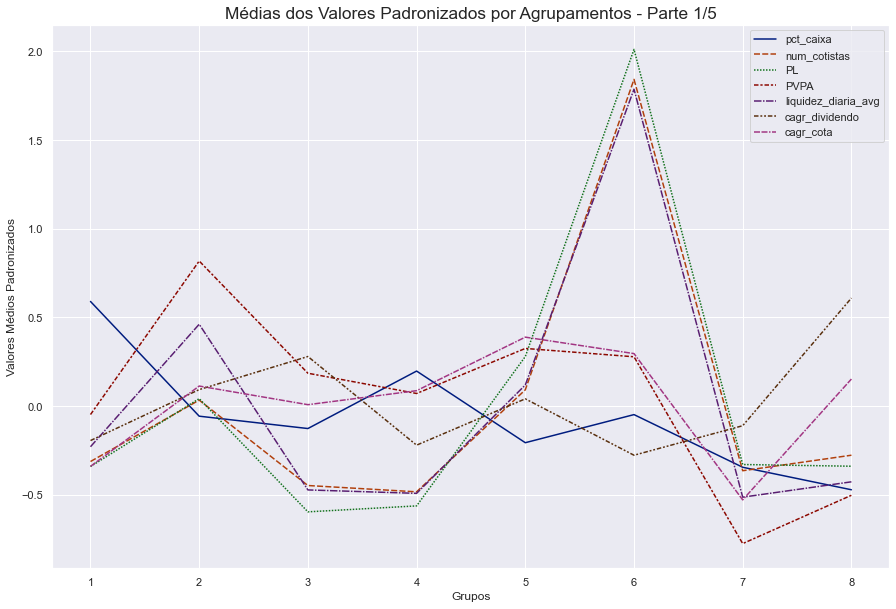

In [75]:
stats_ml = df_std_ml.groupby('cluster').mean()

intervalo = range(7)
parte = 1

def plot_std_by_cluster(df, parte):
    fig = plt.figure(figsize=(15,10))

    sns.lineplot(data = df)

    plt.title(f"Médias dos Valores Padronizados por Agrupamentos - Parte {parte}/5", size='x-large')
    plt.xlabel("Grupos")
    plt.ylabel("Valores Médios Padronizados")
    
    return fig

plot_std_by_cluster(stats_ml.iloc[:,intervalo], parte)
plt.show()

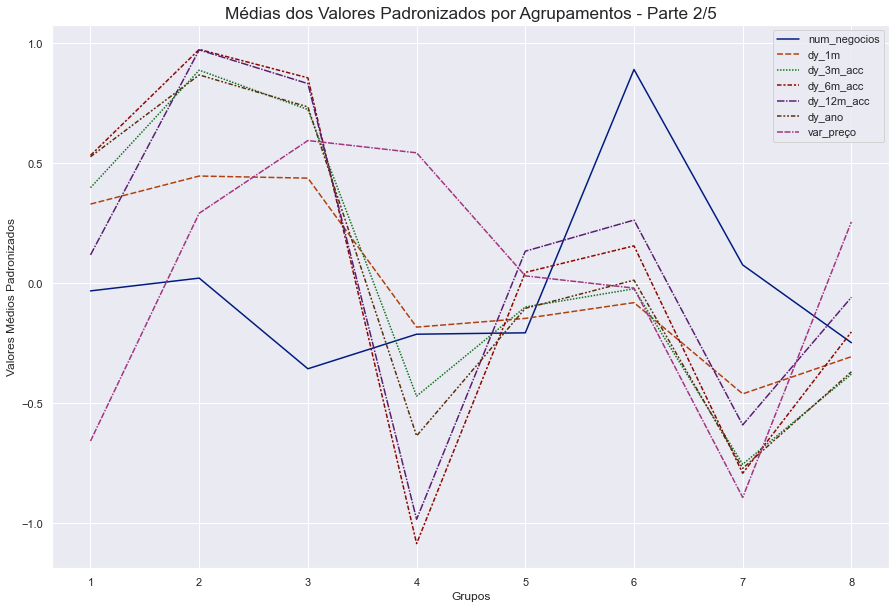

In [76]:
intervalo = range(7,14)
parte = 2

plot_std_by_cluster(stats_ml.iloc[:,intervalo], parte)
plt.show()

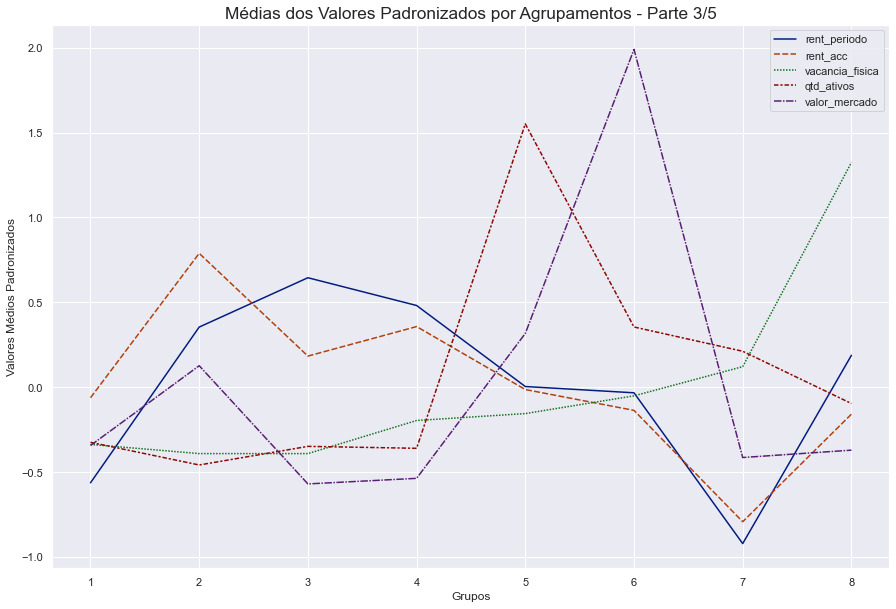

In [77]:
intervalo = range(14,19)
parte = 3

plot_std_by_cluster(stats_ml.iloc[:,intervalo], parte)
plt.show()

Para as variáveis categóricas calcularei a porcentagem de ocorrências de cada "dummy" em determinado agrupamento.
(Logo o total de porcentagem para cada "dummy" será sempre 1, ou 100%)

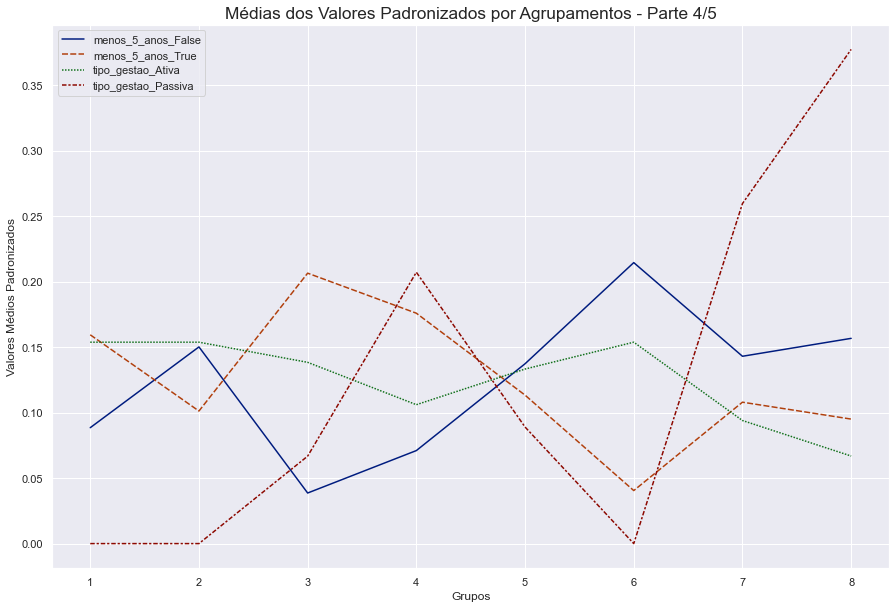

In [82]:
stats_ml_dum = df_dum_ml.groupby('cluster').mean()
stats_ml_dum = stats_ml_dum / stats_ml_dum.sum(axis=0)

intervalo = range(0,4)
parte = 4

plot_std_by_cluster(stats_ml_dum.iloc[:,intervalo], parte)
plt.show()

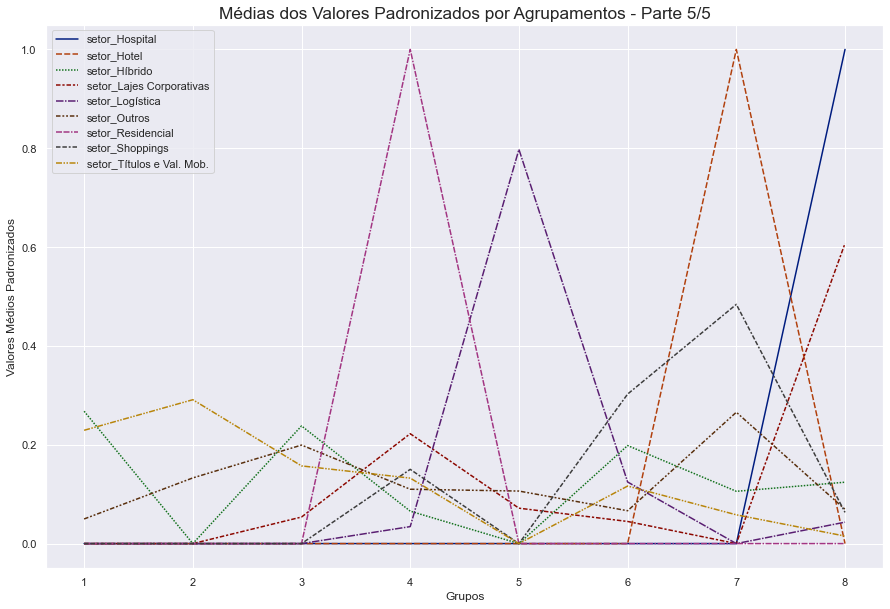

In [83]:
intervalo = range(4,13)
parte = 5

plot_std_by_cluster(stats_ml_dum.iloc[:,intervalo], parte)
plt.show()

Com base nesse gráfico conseguimos extrair características (em média) marcantes dos agrupamentos:

 - **Grupo 1**: 
    - Valores Baixos: `var_preco` (segundo mais baixo), `vacancia_fisica` (segundo mais baixo), `qtd_ativos` (segundo mais baixo)
    - Valores Altos: `pct_caixa`, (terceiro grupo mais alto nos DY em geral), (possui somente FIIs de Papel, Híbridos e Outros), (possui somente Fundos com gestão Ativa)
 - **Grupo 2**:
    - Valores Baixos: `vacancia_fisica`, `qtd_ativos`
    - Valores Altos: `PVPA`, `dy_3m_acc`, `dy_1m`, `dy_12m_acc`, `dy_6m_acc`, `rent_acc`, (possui somente FIIs de Papel e Outros), (possui somente Fundos com gestão Ativa)
 - **Grupo 3**:
    - Valores Baixos: `PL`, `liquidez_diaria`, `num_cotistas`, `valor_mercado`
    - Valores Altos: `cagr_dividendo` (segundo mais alto), `var_preço`, (segundo grupo mais alto nos DY em geral), `rent_periodo`
 - **Grupo 4**:
    - Valores Baixos: `PL`, `liquidez_diaria`, `num_cotistas`, `cagr_dividendo`, `dy_12m_acc`, `dy_6m_acc`, `valor_mercado` (segundo mais baixo)
    - Valores Altos: `setor_residencial` (100% do total), `pct_caixa` (segundo mais alto), `var_preço` (segundo mais alto), `rent_periodo`(segundo mais alto), `rent_acc` (segundo mais alto)
 - **Grupo 5**:
    - Valores Baixos: 
    - Valores Altos: `cagr_cota`, `qtd_ativos`, `setor_logistica` (80% do total), (possui somente FIIs de Logística, Lajes e Outros)
 - **Grupo 6**:
    - Valores Baixos: 
    - Valores Altos: `PL`, `num_cotistas`, `liquidez_diaria_avg`, `num_negocios`, `valor_mercado`, (possui somente Fundos com gestão Ativa)
 - **Grupo 7**:
    - Valores Baixos: `dy_1m`, `dy_3m_acc`, `dy_ano`, `var_preço`, `rent_periodo`, `rent_acc`
    - Valores Altos: `PVPA`, `cagr_cota`, `liquidez_diaria`, `setor_hotel` (100% do total), 
 - **Grupo 8**:
    - Valores Baixos: `PVP`, `pct_caixa`
    - Valores Altos: `cagr_dividendo`, `vacancia_fisica`, `setor_hospital` (100% do total deste), `gestao_passiva` (quase 40% dos FIIs getão passiva estão aqui), `setor_lajes` (60% do total)